<a href="https://colab.research.google.com/github/ZitongZhou/react_inverse/blob/master/inputs_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pickle as pk
import os
import time
from google.colab import drive
from google.colab import files
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
def simple_plot(c_map, title=''):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250

    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    if len(c_map) == 41:
        fig, axs = plt.subplots(1,1)
    #        axs.set_xlabel('x(m)')
    #        axs.set_ylabel('y(m)')
        # axs.set_xlim(0,Lx)
        # axs.set_ylim(0,Ly)
        c01map = axs.imshow(c_map, cmap='jet',
                  extent=[x.min(), x.max(), y.min(), y.max()],
                  vmin=c_map.min(), vmax = c_map.max(),
                  origin='lower')
        fig.colorbar(c01map, ax=axs,shrink=0.62)
    else:
        fig, axs = plt.subplots(len(c_map)//3, 3, figsize=(7, 2.5))
        axs = axs.flat
        for i, ax in enumerate(axs):
            # ax.set_xlim(0,Lx)
            # ax.set_ylim(0,Ly)
            c01map = ax.imshow(c_map[i], cmap='jet', interpolation='nearest',
                      extent=[x.min(), x.max(), y.min(), y.max()],
                      vmin=c_map[i].min(), vmax = c_map[i].max(),
                      origin='lower')
            ax.set_axis_off()
            v1 = np.linspace(np.min(c_map[i]),np.max(c_map[i]), 5, endpoint=True)
            fig.colorbar(c01map, ax=ax, fraction=0.021, pad=0.04,ticks=v1,)

    plt.suptitle(title)
    name = title + '.pdf'
    plt.tight_layout()
#         fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
    plt.show()
    return

In [3]:
dir = os.listdir('/content/drive/MyDrive/react_inverse/simu_outputs/')
os.chdir('/content/drive/MyDrive/react_inverse/simu_outputs/')
len(dir)

694

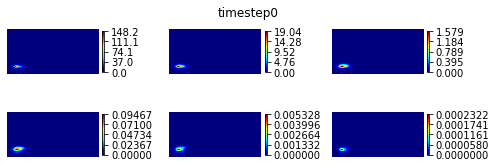

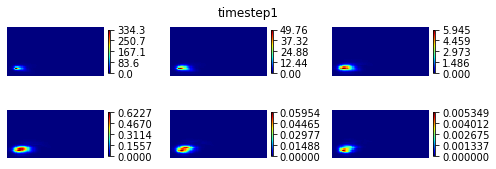

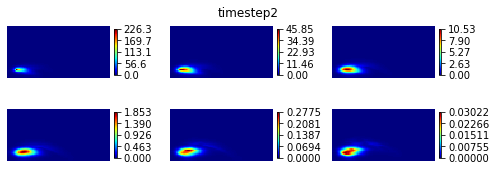

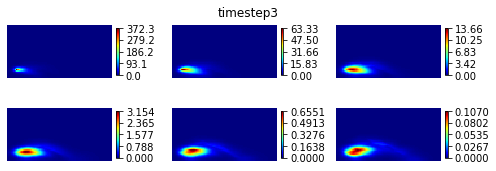

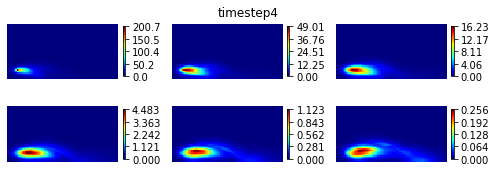

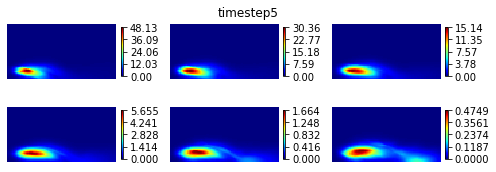

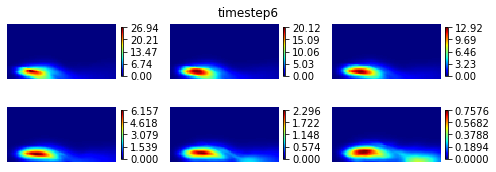

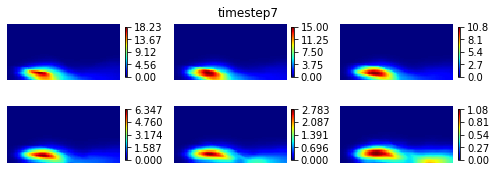

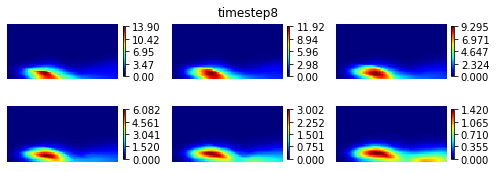

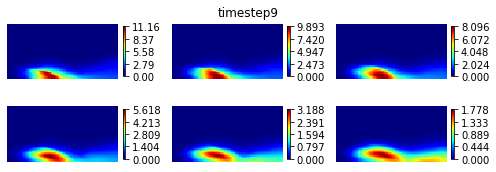

In [4]:
out_test = dir[0]
f = h5py.File(out_test, "r")
conc = np.array(f['concentration'])
conc[conc<0] = 0
head = np.array(f['head'])
f.close()
for i in range(len(conc)):
    simple_plot(conc[i], 'timestep'+str(i))

## Read input and output files, pickle as dataset

In [5]:
## make autoregressive dataset: conc[t] + S[t] + kd ----> conc[t+1] + head, 
## skip the file that does not have the corresponding output file, or the output
## concentration length is not 10.
AR_input = []
AR_output = []
problematic_conc = []
dir = os.listdir('/content/drive/MyDrive/react_inverse/simu_outputs/')
os.chdir('/content/drive/MyDrive/react_inverse/simu_outputs/')
##len(dir)=4999, but it's too big
N_simu = 500
n_data = 0
file_ind = 0
file_inds = []
pbar = tqdm(total=N_simu)
while n_data < N_simu:
    file_ind += 1
    output_name = dir[file_ind-1]
    try:
        f = h5py.File(output_name, "r")
    except:
        continue
    ## output_name[7:] includes the index of the output file: 275.hdf5
    file_inds.append(output_name[7:])
    input_name = '/content/drive/MyDrive/react_inverse/simu_inputs/input_' + output_name[7:]
    ## input: kd(6, 41, 81), welspd(5,[5]), [5]: loc+conc+type 
    input_file =  h5py.File(input_name, 'r')
    kd = np.array(input_file['kd'])
    welspd = np.array(input_file['welspd'])
    input_file.close()

    conc = np.array(f['concentration'])
    conc[conc<0] = 0
    head = np.array(f['head'])
    f.close()
    ## S: release for 5 steps
    if len(conc) != 10:
        problematic_conc.append(output_name[7:])
    else:
        conc = np.concatenate((np.zeros((1, 6, 41, 81)), conc), axis=0)
        S = np.zeros((len(conc)-1, 6, 41, 81))
        for i in range(len(welspd)-1):
            S[i, int(welspd[i,0]), int(welspd[i,1]), int(welspd[i,2])] = welspd[i,3]
        for i in range(len(conc)-1):
            AR_input.append([conc[i], kd, S[i]])
            AR_output.append([conc[i+1], head])
    n_data += 1
    pbar.update(1)

pbar.close()
print('\n',len(AR_input))
print(len(AR_input[0]))

100%|██████████| 500/500 [09:28<00:00,  1.14s/it]


 5000
3


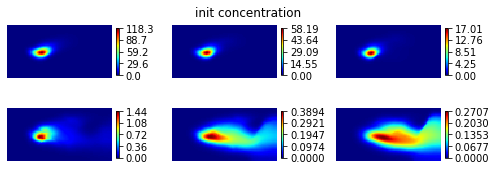

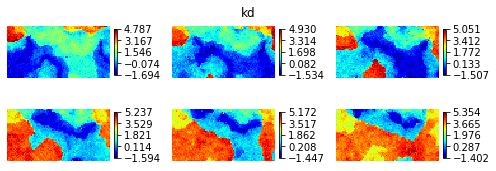

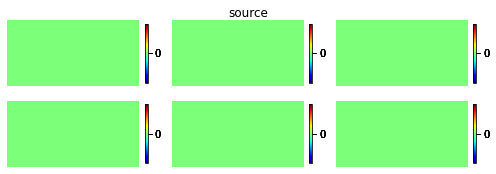

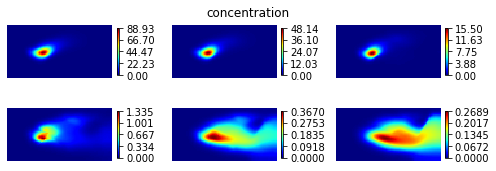

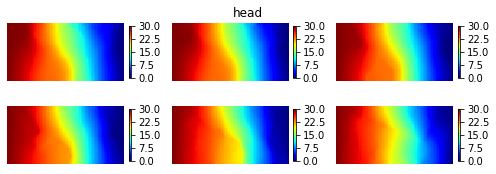

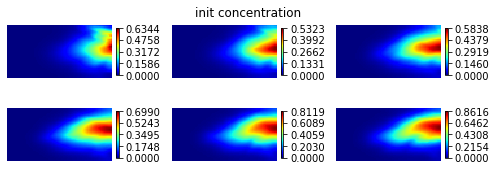

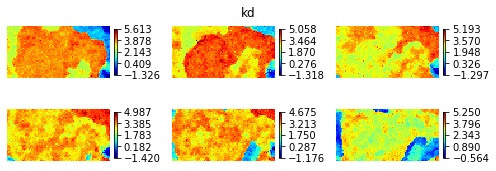

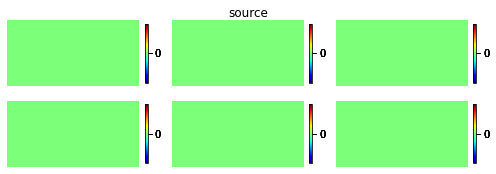

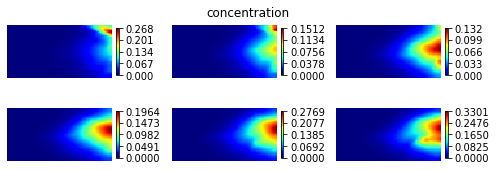

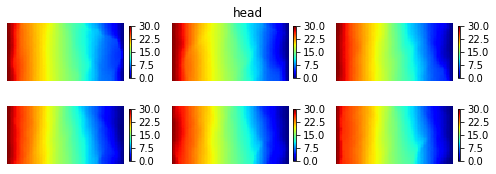

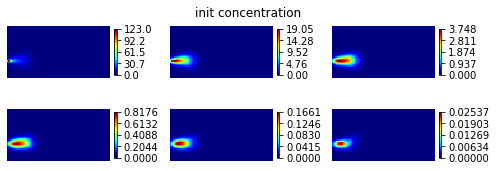

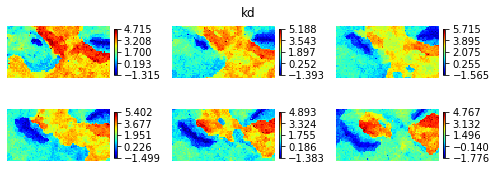

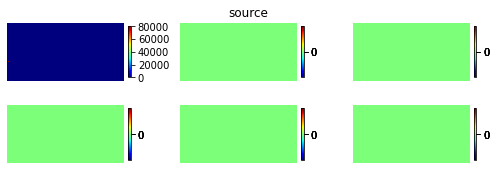

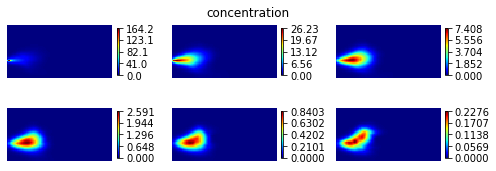

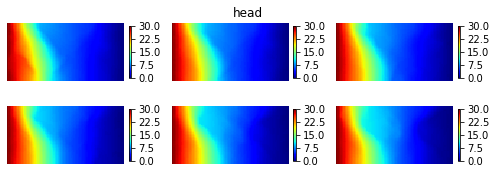

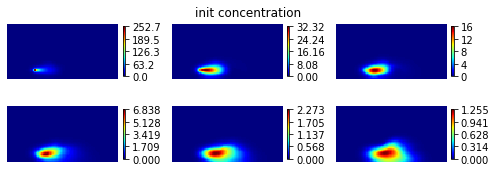

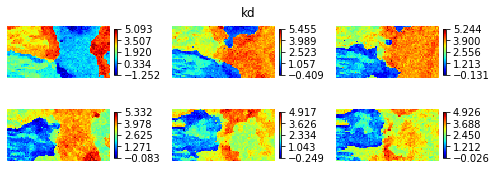

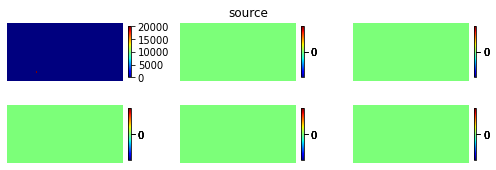

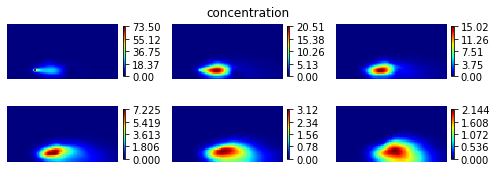

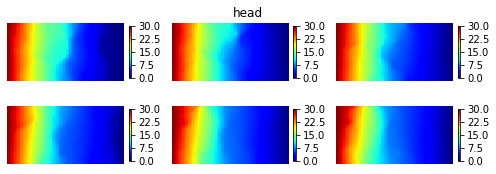

In [14]:
np.random.seed(88)
ind = np.random.randint(0, len(AR_input), 4)

for i in ind:
    input = AR_input[i].copy()
    output = AR_output[i].copy()
    simple_plot(input[0], 'init concentration')
    simple_plot(input[1], 'kd')
    simple_plot(input[2], 'source')
    simple_plot(output[0], 'concentration')
    simple_plot(output[1], 'head')

In [ ]:
file_inds = [int(''.join(c for c in i if c.isdigit())) for i in file_inds]
file_inds

In [13]:
## save AR_input and AR_output in hdf5 file
hf =  h5py.File('/content/drive/MyDrive/react_inverse/training_data/AR_dataset_{}.hdf5'.format(str(N_simu)), 'w')
hf.create_dataset('input', data = AR_input, dtype ='f', compression = 'gzip')
hf.create_dataset('output', data = AR_output, dtype ='f', compression = 'gzip')
hf.create_dataset('file_inds', data = file_inds, dtype='f', compression = 'gzip')
hf.close()

## Make input files

In [ ]:
with open('/content/drive/MyDrive/react_inverse/training_data/kds.pkl', 'rb') as file:
    kds = pk.load(file)

In [ ]:
assert len(kds[0])==6 and len(kds[0][0])==41 and len(kds[0][0][0])==81, \
    'size error, should be [6, 41, 81]'+str([len(kds[0]), len(kds[0][0]), len(kds[0][0][0])])

In [ ]:
N = 5000
# local_state = np.random.RandomState(seed = None)

### x
np.random.seed(888)
y_wel = np.array([6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34])# #np.random.randint(low = 5, high = 35, size = 20)
x_wel = np.array([1, 1, 1, 1, 1, 
         7, 7, 7, 7, 7,
         13, 13, 13, 13, 13,
         20, 20, 20, 20, 20])# #np.random.randint(low = 0, high = 25, size = 20)
wells = {i: [y_wel[i], x_wel[i]] for i in range(len(y_wel))}

x_ind = np.random.choice(20, N)

x = [wells[x_ind[i]] for i in range(N)]

### q
q = 10000 + 5000*np.random.randint(low=0, high=18, size=(N, 5))

### make well stress period data:
con_rate = []
for sim in range(N):
    welspd = []
    for i in range(5):
        welspd.append([0, x[sim][0], x[sim][1], q[sim, i], 15])
    welspd.append([0, x[sim][0], x[sim][1], 0, 15])
    con_rate.append(welspd)
con_rate = np.array(con_rate)

In [ ]:
con_rate[199]

array([[    0,    20,    13, 75000,    15],
       [    0,    20,    13, 50000,    15],
       [    0,    20,    13, 35000,    15],
       [    0,    20,    13, 95000,    15],
       [    0,    20,    13, 30000,    15],
       [    0,    20,    13,     0,    15]])

In [ ]:
N = 5000
for ndata in range(N):
    hf =  h5py.File('/content/drive/MyDrive/react_inverse/simu_inputs/input_{}.hdf5'.format(ndata), 'w')
    hf.create_dataset('kd', data = kds[ndata], dtype ='f', compression = 'gzip')
    hf.create_dataset('welspd', data = con_rate[ndata], dtype ='f', compression = 'gzip')
    hf.close()